In [1]:
import EOBRun_module
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.constants as const
from scipy.optimize import minimize
import astropy.constants as aconst
from pycbc.waveform import td_approximants, fd_approximants, get_td_waveform
from pycbc.detector import Detector
from pycbc.filter import match, optimized_match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types import timeseries
from calcwf import *

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


We have implicitly assumed so far that the reference frequency of the waveforms was the Keplerian frequency. This is not the case for TEOBResumS, where the reference frequency is defined as the average of the peri- and apastron frequencies. If we are therefore able to convert from the Keplerian frequency ($\omega_\textrm{kep}$) to this TEOBResumS average frequency ($\omega_\textrm{avg}$) we should be able to increase eccentricity while keeping the initial Keplerian frequency constant. This should then give a decreased signal length as we would expect.

Equation 3 in https://arxiv.org/pdf/2207.14346.pdf gives the instantaneous orbital frequency as follows:

$$
\omega (t) = \frac{\omega_\textrm{kep} \sqrt{1-e^2}}{\left[ 1-e\cos{E(t)}\right]^2}
$$

The frequency is highest (lowest) at the periastron (apastron). Therefore $\omega_\textrm{peri}$ ($\omega_\textrm{ap}$) corresponds to when $\cos{E(t)} = +1$ ($-1$). Therefore the average frequency used in TEOBResumS is given by:

$$
\omega_\textrm{avg} = \frac{1}{2} \left( \omega_\textrm{peri} + \omega_\textrm{ap} \right) = \frac{1}{2} \left( \frac{\omega_\textrm{kep} \sqrt{1-e^2}}{\left[ 1-e\right]^2} + \frac{\omega_\textrm{kep} \sqrt{1-e^2}}{\left[1+e\right]^2} \right)
$$

$$
\omega_\textrm{avg} = \frac{\omega_\textrm{kep} \sqrt{1-e^2}}{2} \left( \frac{ \left(1+e\right)^2 + \left(1-e\right)^2}{\left(1+e\right)^2 \left(1-e\right)^2} \right)
$$

$$
\omega_\textrm{avg} = \omega_\textrm{kep} \frac{\left(1+e^2\right) \sqrt{1-e^2}}{\left(1+e\right)^2 \left(1-e\right)^2}
$$

$$
\omega_\textrm{avg} = \omega_\textrm{kep} \frac{\left(1+e^2\right)}{\left(1-e^2\right)^{3/2}}~~~~~\textrm{or equivalently}~~~~~f_\textrm{avg} = f_\textrm{kep} \frac{\left(1+e^2\right)}{\left(1-e^2\right)^{3/2}}
$$

Can now write functions converting between $f_\textrm{kep}$ and $f_\textrm{avg}$.

In [2]:
def f_kep2avg(f_kep, e):

    numerator = (1+e**2)
    denominator = (1-e**2)**(3/2)

    return f_kep*(numerator/denominator)

def f_avg2kep(f_avg, e):

    numerator = (1-e**2)**(3/2)
    denominator = (1+e**2)

    return f_avg*(numerator/denominator)

In [3]:
# Converts modes to use into language TEOBResumS understands
def modes_to_k(modes):
    return [int(x[0]*(x[0]-1)/2 + x[1]-2) for x in modes]

In [4]:
# Generates TEOBResumS waveform with given parameters
def gen_teob_wf(f_kep, e, M, q, sample_rate, phase):

    f_avg = f_kep2avg(f_kep, e)

    # Define parameters
    k = modes_to_k([[2,2]])
    pars = {
            'M'                  : M,
            'q'                  : q,
            'Lambda1'            : 0.,
            'Lambda2'            : 0.,     
            'chi1'               : 0.,
            'chi2'               : 0.,
            'domain'             : 0,            # TD
            'arg_out'            : 0,            # Output hlm/hflm. Default = 0
            'use_mode_lm'        : k,            # List of modes to use/output through EOBRunPy
            'srate_interp'       : sample_rate,  # srate at which to interpolate. Default = 4096.
            'use_geometric_units': 0,            # Output quantities in geometric units. Default = 1
            'initial_frequency'  : f_avg,        # in Hz if use_geometric_units = 0, else in geometric units
            'interp_uniform_grid': 1,            # Interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
            'distance'           : 1,
            'coalescence_angle'  : phase,
            'inclination'        : 0,
            'ecc'                : e,
            'output_hpc'         : 0,
            }

    # Calculate waveform and convert to pycbc TimeSeries object
    t, teob_p, teob_c = EOBRun_module.EOBRunPy(pars)
    teob = teob_p - 1j*teob_c
    tmrg = t[np.argmax(np.abs(teob))]
    t = t - tmrg
    teob_p = timeseries.TimeSeries(teob_p, 1/sample_rate, epoch=t[0])
    teob_c = timeseries.TimeSeries(teob_c, 1/sample_rate, epoch=t[0])
    
    return teob_p, teob_c

Now input (and plot) two indentical sets of parameters except one with higher eccentricity

In [5]:
hp, hc = gen_teob_wf(10, 0.1, 30, 2, 4096, 0)
sp, sc = gen_teob_wf(10, 0.2, 30, 2, 4096, 0)

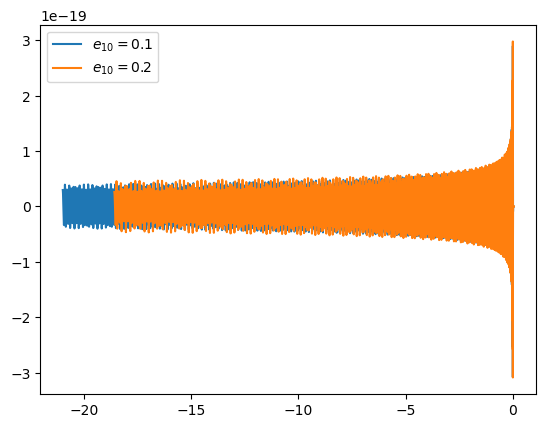

In [6]:
plt.plot(hp.sample_times, hp, label='$e_{10} = 0.1$')
plt.plot(sp.sample_times, sp, label='$e_{10} = 0.2$')
plt.legend()

Now higher eccentricity does indeed give lower signal length as we expect due to the faster orbital evolution!

Finally, we should plot waveforms with shifted $f_\textrm{kep}$ using orbital evolution equations to give a shift in true anomaly by 2pi. If our problem has been fixed, the equations should be accurate, and the envelopes of the waveforms should line up.

In [7]:
from calcwf import shifted_f, shifted_e

In [8]:
hp, hc = gen_teob_wf(10, 0.1, chirp2total(24, 2), 2, 4096, 0)
s_f = shifted_f(10, 0.1, chirp2total(24, 2), 2)
s_e = shifted_e(s_f, 10, 0.1)
sp, sc = gen_teob_wf(s_f, s_e, chirp2total(24, 2), 2, 4096, 0)

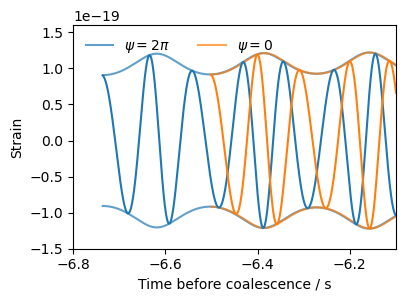

In [9]:
plt.figure(figsize=(0.65*6.4,0.65*4.8))
plt.plot(sp.sample_times, np.sqrt(sp**2 + sc**2), label='$\psi=2\pi$', alpha=0.7)
plt.plot(hp.sample_times, np.sqrt(hp**2 + hc**2), label='$\psi=0$', alpha=0.7)
plt.plot(sp.sample_times, -np.sqrt(sp**2 + sc**2), c='C0', alpha=0.7)
plt.plot(hp.sample_times, -np.sqrt(hp**2 + hc**2), c='C1', alpha=0.7)
plt.plot(sp.sample_times, sp, c='C0')
plt.plot(hp.sample_times, hp, c='C1')
plt.legend(loc='upper left', frameon=False, ncol=2)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Strain')
plt.xlim(-6.8, -6.1)
plt.ylim(-1.5e-19, 1.6e-19)
plt.tight_layout()
plt.savefig('Figures/2piTA.pdf')

Success!

# Shifting phase

We should also be able to shift the phase to be in line analytically as well. Any waveform (with the default phase value) starts with $\psi_0 = \Omega_0 = 0$, where $\psi_0$ and $\Omega_0$ describe the initial phase and argument of apoapsis respectively. For a waveform shifted back by $2\pi$ in mean anomaly, when it reaches the start of the original waveform after completing one amplitude modulation it has $\psi = \Omega = \Delta \phi \left(1 - \frac{\Delta \phi}{2\pi}\right)^{-1}$.

Therefore all we need to do to generate make the second waveform in phase with the original is to generate it with an initial phase of $\psi_0 = \Delta \phi \left(1 - \frac{\Delta \phi}{2\pi}\right)^{-1}$.

In [18]:
# Parameters
f_low = 10
e = 0.2
chirp = 24
q = 2
sample_rate = 4096

In [16]:
total_mass_kg = chirp2total(chirp, q)*aconst.M_sun.value

# Create original waveform
h = gen_wf(f_low, e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS')

# Calculate shifts in frequency and eccentricity
s_f = shifted_f(f_low, e, chirp2total(chirp, q), q)
s_e = shifted_e(s_f, f_low, e)

# Calculate phase shift
P = P_from_f(f_low)
s_phase = -peri_advance_orbit(P, e, total_mass_kg)*num_orbits(P, e, total_mass_kg)

# Create shifted waveform
s = gen_wf(s_f, s_e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS', phase=s_phase)

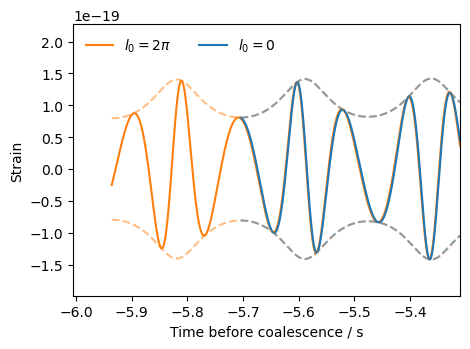

In [17]:
# Make plot, shifting arbitrary amount in mean anomaly
plt.figure(figsize=(0.75*6.4,0.75*4.8))
plt.plot(s.sample_times, s.real(), c='C1', label='$l_0=2\pi$')
plt.plot(h.sample_times, h.real(), c='C0', label='$l_0=0$')
plt.plot(s.sample_times, np.abs(s), c='C1', ls='dashed', alpha=0.5)
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.plot(s.sample_times, -np.abs(s), c='C1', ls='dashed', alpha=0.5)
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.legend(loc='upper left', frameon=False, ncol=2)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Strain')
len_2pi = h.sample_times[0]-s.sample_times[0]
plt.xlim(s.sample_times[0]-0.3*len_2pi, h.sample_times[0]+1.7*len_2pi)
max_h = max(np.abs(h[:int(1.7*len_2pi*sample_rate)]))
plt.ylim(-1.4*max_h, 1.6*max_h)
plt.tight_layout()

The more general case is a little trickier. We will still start at apoapsis with $\psi_0 = \Omega_0 = 0$ by default, however will now join the original waveform at $\Omega = \frac{M}{2\pi} \Delta \phi \left(1 - \frac{\Delta \phi}{2\pi}\right)^{-1}$, with $M$ being the mean anomaly we are shifting by. At this point, the phase has evolved to $\psi = \Omega + T$ where $T$ is the true anomaly corresponding to the mean anomaly $M$. We must therefore simply generate the second waveform with a phase of $\psi_0 = \frac{M}{2\pi} \Delta \phi \left(1 - \frac{\Delta \phi}{2\pi}\right)^{-1} - T$.

$T$ is defined in terms of $M$ only as an infinite series. We can use pre-existing python packages however to find very accurate conversions very quickly.

In [12]:
from orbital import true_anomaly_from_mean

In [30]:
# Parameters
f_low = 10
e = 0.2
chirp = 24
q = 2
sample_rate = 4096
MA_shift = 1.735243

In [35]:
total_mass_kg = chirp2total(chirp, q)*aconst.M_sun.value

# Create original waveform
h = gen_wf(f_low, e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS')

# Calculate shifts in frequency and eccentricity
s_f_2pi = f_low - shifted_f(f_low, e, chirp2total(chirp, q), q)
s_f = f_low - MA_shift*s_f_2pi/(2*np.pi)
s_e = shifted_e(s_f, f_low, e)

# Calculate phase shift
P = P_from_f(f_low)
T = true_anomaly_from_mean(e, MA_shift)
s_phase = -MA_shift*peri_advance_orbit(P, e, total_mass_kg)*num_orbits(P, e, total_mass_kg)/(2*np.pi) - T

# Create shifted waveform
s = gen_wf(s_f, s_e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS', phase=s_phase)

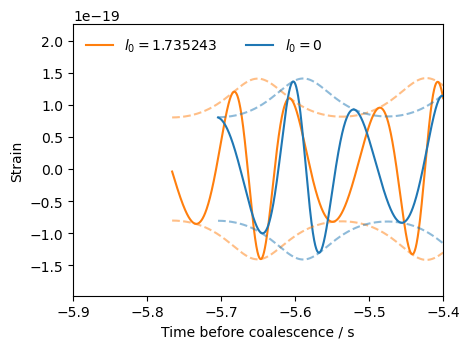

In [32]:
# Make plot, shifting arbitrary amount in mean anomaly
plt.figure(figsize=(0.75*6.4,0.75*4.8))
plt.plot(s.sample_times, s.real(), c='C1', label=f'$l_0={MA_shift}$')
plt.plot(h.sample_times, h.real(), c='C0', label='$l_0=0$')
plt.plot(s.sample_times, np.abs(s), c='C1', ls='dashed', alpha=0.5)
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.plot(s.sample_times, -np.abs(s), c='C1', ls='dashed', alpha=0.5)
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.legend(loc='upper left', frameon=False, ncol=2)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Strain')
plt.xlim(-5.9, -5.4)
plt.ylim(-1.4*max_h, 1.6*max_h)
plt.tight_layout()

It is hard to visually tell for arbitrary mean anomaly shifts how accurate this is. Instead, let's compare the numerical phase shift we calculated to our previous method of finding the phase of the waveforms with default phase values.

In [150]:
# Parameters
f_low = 10
e = 0.5
chirp = 24
q = 2
sample_rate = 4096
MA_shift = 0.463542

In [151]:
total_mass_kg = chirp2total(chirp, q)*aconst.M_sun.value

# Create original waveform
h = gen_wf(f_low, e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS')

# Calculate shifts in frequency and eccentricity
s_f_2pi = f_low - shifted_f(f_low, e, chirp2total(chirp, q), q)
s_f = f_low - MA_shift*s_f_2pi/(2*np.pi)
s_e = shifted_e(s_f, f_low, e)

# Calculate phase shift analytically
P = P_from_f(f_low)
T = (true_anomaly_from_mean(e, MA_shift+np.pi)-np.pi)%(2*np.pi)
s_phase = -MA_shift*peri_advance_orbit(P, e, total_mass_kg)*num_orbits(P, e, total_mass_kg)/(2*np.pi) - MA_shift
print(f'True anomaly: {T}')
print(f'Analytic phase shift: {s_phase}')
a = gen_wf(s_f, s_e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS', phase=s_phase)

# Calculate phase shift by generating waveform
s = gen_wf(s_f, s_e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS')
overlap = overlap_cplx_wfs(s, h, f_low)
phase_angle = np.angle(overlap)/2
print(f'Extra waveform generation phase shift: {phase_angle}')
b = gen_wf(s_f, s_e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS', phase=phase_angle)

print(f'Difference: {phase_angle-s_phase}')

True anomaly: 0.18034122990852008
Analytic phase shift: -0.5619186976616302
Extra waveform generation phase shift: -0.6744851881495362
Difference: -0.11256649048790601


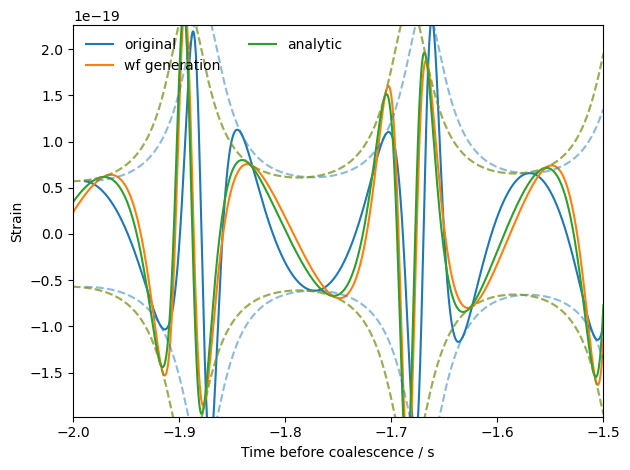

In [155]:
# Make plot, shifting arbitrary amount in mean anomaly
plt.plot(h.sample_times, h.real(), c='C0', label='original')
plt.plot(b.sample_times, b.real(), c='C1', label='wf generation')
plt.plot(a.sample_times, a.real(), c='C2', label='analytic')
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.plot(b.sample_times, np.abs(b), c='C1', ls='dashed', alpha=0.5)
plt.plot(a.sample_times, np.abs(a), c='C2', ls='dashed', alpha=0.5)
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.plot(b.sample_times, -np.abs(b), c='C1', ls='dashed', alpha=0.5)
plt.plot(a.sample_times, -np.abs(a), c='C2', ls='dashed', alpha=0.5)
plt.legend(loc='upper left', frameon=False, ncol=2)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Strain')
plt.xlim(-2, -1.5)
plt.ylim(-1.4*max_h, 1.6*max_h)
plt.tight_layout()

It seems like using mean anomaly is actually correct instead of true anomaly, which is a surprise to me. Will have to think about why this is.

# TEOBResumS-Dali

Using the Dali branch of teobresums instead of the 'eccentric' branch (outdated, no longer supported), we now have the options to specify both an orbit averaged frequency, and the initial anomaly of the waveform. In this section we will check that these are equivalent to the approaches above.

This will require us to convert from mean to true anomaly again. In order to not be dependent on too many other packages, will write simple implementation myself here. First off will need to find eccentric anomaly from mean anomaly with a root solving algorithm (scipy minimize), and can then convert analytically to true anomaly.

In [2]:
def EA2MA(EA, e):
    MA = EA - e*np.sin(EA)
    return MA

def MA2EA(MA, e):
    bounds = [(0, 2*np.pi)]
    init_guess = MA
    best_fit = minimize(lambda x: np.abs(MA - EA2MA(x, e)), init_guess, bounds=bounds)
    EA = best_fit['x'][0]
    return EA

def EA2TA(EA, e):
    arg_num = np.sqrt(1+e)*np.sin(EA/2)
    arg_denom = np.sqrt(1-e)*np.cos(EA/2)
    TA = 2*np.arctan2(arg_num, arg_denom)
    return TA

def TA2EA(TA, e):
    arg_num = np.sqrt(1-e**2)*np.sin(TA)
    arg_denom = e+np.cos(TA)
    EA = np.arctan2(arg_num, arg_denom)
    EA = EA%(2*np.pi)
    return EA

def MA2TA(MA, e):
    TA = EA2TA(MA2EA(MA, e), e)
    return TA

def TA2MA(TA, e):
    MA = EA2MA(TA2EA(TA, e), e)
    return MA

In [91]:
print(MA2TA(1.8343, 0.2))
print(TA2MA(2.189308959512313, 0.2))

2.189308959512313
1.8342999974122622


In [4]:
# Generates TEOBResumS waveform with given parameters
def test_teob_wf(input_f, e, M, q, sample_rate, phase, ecc_freq, MA=np.pi, built_in_anom=False):

    # Handle frequency definitions
    if ecc_freq == 'average':
        f_avg = f_kep2avg(input_f, e)
        ecc_freq_id = 1
    elif ecc_freq == 'orbitaveraged':
        f_avg = input_f
        ecc_freq_id = 3

    # Handle different mean anomalies
    if built_in_anom:
        TA = TA2MA(MA, e)
        print(MA, TA)
    else:
        MA_shift = (MA + np.pi)%(2*np.pi)
        s_f_2pi = f_avg - shifted_f(f_avg, e, M, q)
        s_f = f_avg - MA_shift*s_f_2pi/(2*np.pi)
        s_e = shifted_e(s_f, f_avg, e)
        f_avg, e, = s_f, s_e
        TA = np.pi        

    # Define parameters
    k = modes_to_k([[2,2]])
    pars = {
            'M'                  : M,
            'q'                  : q, 
            'chi1'               : 0.,
            'chi2'               : 0.,
            'domain'             : 0,            # TD
            'arg_out'            : 'no',         # Output hlm/hflm. Default = 0
            'use_mode_lm'        : k,            # List of modes to use/output through EOBRunPy
            'srate_interp'       : sample_rate,  # srate at which to interpolate. Default = 4096.
            'use_geometric_units': 'no',         # Output quantities in geometric units. Default = 1
            'initial_frequency'  : f_avg,        # in Hz if use_geometric_units = 0, else in geometric units
            'interp_uniform_grid': 'yes',        # Interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
            'distance'           : 1,
            'coalescence_angle'  : phase,
            'inclination'        : 0,
            'ecc'                : e,
            'output_hpc'         : 'no',
            'ecc_freq'           : ecc_freq_id,
            'anomaly'            : TA
            }

    # Calculate waveform and convert to pycbc TimeSeries object
    t, teob_p, teob_c = EOBRun_module.EOBRunPy(pars)
    
    teob = teob_p - 1j*teob_c
    tmrg = t[np.argmax(np.abs(teob))]
    t = t - tmrg
    teob_p = timeseries.TimeSeries(teob_p, 1/sample_rate, epoch=t[0])
    teob_c = timeseries.TimeSeries(teob_c, 1/sample_rate, epoch=t[0])
    
    return teob_p - 1j*teob_c

First let's compare specifying an orbit average frequency to the conversion function we have written.

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


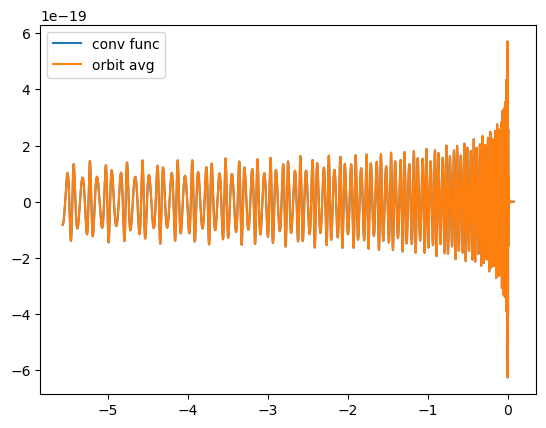

In [50]:
# Generate waveforms
conv = test_teob_wf(10, 0.2, 60, 2, 4096, 0, 'average')
orbavg = test_teob_wf(10, 0.2, 60, 2, 4096, 0, 'orbitaveraged')

# Make comparison plot
plt.plot(conv.sample_times, conv, label='conv func')
plt.plot(orbavg.sample_times, orbavg, label='orbit avg')
plt.legend()

This indeed seems to be equivalent.

Now we should check that the new anomaly parameter is indeed true anomaly, once again by comparing against our solution/workaround.

5.5 5.753923153072458


(-2e-19, 2e-19)

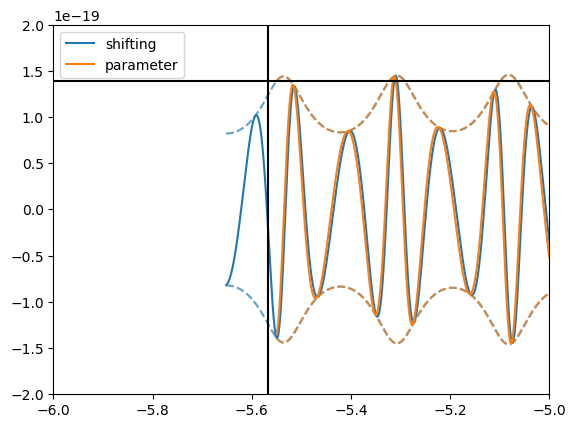

In [151]:
# Generate waveforms
base = test_teob_wf(10, 0.2, 60, 2, 4096, 0, 'orbitaveraged', MA=np.pi, built_in_anom=False)
base_time = base.sample_times[0]
shifting = test_teob_wf(10, 0.2, 60, 2, 4096, 0, 'orbitaveraged', MA=5.5, built_in_anom=False)
param = test_teob_wf(10, 0.2, 60, 2, 4096, 0, 'orbitaveraged', MA=5.5, built_in_anom=True)

# Make comparison plot
plt.plot(shifting.sample_times, shifting, c='C0', label='shifting')
plt.plot(shifting.sample_times, np.abs(shifting), c='C0', ls='dashed', alpha=0.7)
plt.plot(shifting.sample_times, -np.abs(shifting), c='C0', ls='dashed', alpha=0.7)
plt.plot(param.sample_times, param, c='C1', label='parameter')
plt.plot(param.sample_times, np.abs(param), c='C1', ls='dashed', alpha=0.7)
plt.plot(param.sample_times, -np.abs(param), c='C1', ls='dashed', alpha=0.7)
plt.axvline(base_time, c='k')
plt.axhline(np.abs(param[0]), c='k')
plt.legend()
plt.xlim(-6,-5)
plt.ylim(-2e-19, 2e-19)

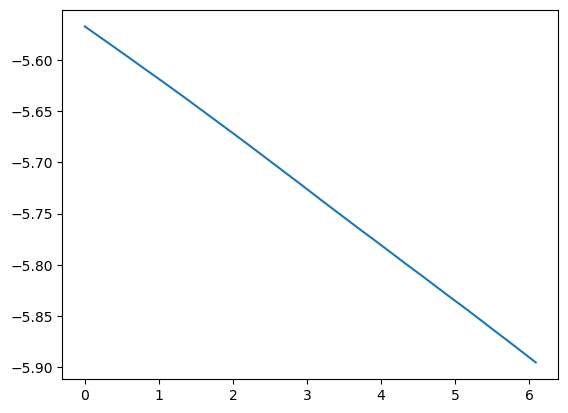

In [7]:
times = []
for i in range(32):
    h = test_teob_wf(10, 0.2, 60, 2, 4096, 0, 'average', MA=i*2*np.pi/32+np.pi, built_in_anom=False)
    times.append(h.sample_times[0])
plt.plot(np.linspace(0,2*np.pi, 32, endpoint=False), times)

0.0 0.0
0.7853981633974483 0.5308593165554508
1.5707963267948966 1.1734792265819114
2.356194490192345 2.0412543939062435
3.141592653589793 3.141592653589793
3.9269908169872414 4.241930913273342
4.71238898038469 5.109706080597675
5.497787143782138 5.752325990624135


(-2e-19, 2e-19)

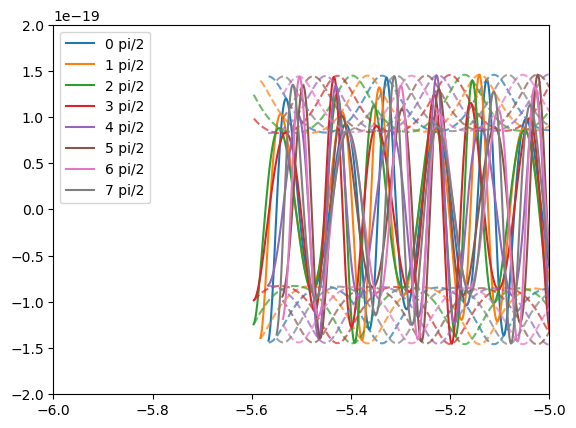

In [10]:
for i in range(8):
    h = test_teob_wf(10, 0.2, 60, 2, 4096, 0, 'orbitaveraged', MA=i*np.pi/4, built_in_anom=True)
    plt.plot(h.sample_times, h, c=f'C{i}', label=f'{i} pi/2')
    plt.plot(h.sample_times, abs(h), c=f'C{i}', ls='dashed', alpha=0.7)
    plt.plot(h.sample_times, -abs(h), c=f'C{i}', ls='dashed', alpha=0.7)
plt.legend()
plt.xlim(-6,-5)
plt.ylim(-2e-19, 2e-19)